In [47]:
import pandas as pd
import numpy as np
import torch
import os
import sys

sys.path.append('Datasets/')
sys.path.append('models/')

import datasets
import audio_utils
import models

In [48]:
SCAPPER_DF = pd.read_csv('predictions/scapper_scenePredictions_model00.csv')
SCAPPER_AUD_DIR = '../audioData/sythenticSoundscenes/test'
scapper_acoustic_scenes = (list)(SCAPPER_DF['acoustic_scene_label'].unique())

In [49]:
model_path = 'ASC_Model00_scapper_20epochs_00_statedict.pt'
model = models.ASC_Model00(return_second_last=False)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [125]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

def get_logMel_from_fname(audio_fname):
    audio = audio_utils.load_audio_from_file(audio_fname)
    log_mel = audio_utils.get_log_melSpectrogram(audio)
    return log_mel

def zero_signal(log_mel, index):
    log_mel[0][index] = torch.ones(log_mel[0][index].shape) * log_mel.min()
    return log_mel

def run_loop(audio_fname, model):
    feat_inva_output_list = []
    input_feats = get_logMel_from_fname(audio_fname)

    n_features = input_feats.shape[1]

    for i in range(n_features):
        input_feats = get_logMel_from_fname(audio_fname)
        input_log_mel = zero_signal(input_feats, i)

        model.eval()
        with torch.inference_mode():
            predictions = model(input_log_mel.unsqueeze(0).to(device))
            predictions = scapper_acoustic_scenes[torch.argmax(torch.sigmoid(predictions.cpu()))]
            print(predictions)
        feat_inva_output_list.append(predictions)
    return feat_inva_output_list


In [126]:
import random
randomly_chosen_files = {}

for i in scapper_acoustic_scenes:
    randomly_chosen_files[i] = []

scapper_true = SCAPPER_DF[SCAPPER_DF['acoustic_scene_label'] == SCAPPER_DF['ASC_predictions_model00']]
    

In [127]:
for i in scapper_acoustic_scenes:
    rand = (list)(scapper_true[scapper_true['acoustic_scene_label'] == i]['audio_fileNames'])
    random.seed(42)
    randomly_chosen_files[i].append(random.sample(rand,10))

In [128]:
predictions_dictionary = {}

for i in scapper_acoustic_scenes:
    for j in randomly_chosen_files[i][0]:
        audio_fname = os.path.join(SCAPPER_AUD_DIR, j)
        predictions_dictionary[audio_fname] = run_loop(audio_fname, model)
        

restaurant
openairmarket
bus
bus
bus
bus
bus
bus
supermarket
tube
bus
bus
bus
restaurant
bus
bus
restaurant
tube
bus
bus
bus
supermarket
bus
bus
restaurant
tube
bus
bus
bus
restaurant
bus
bus
restaurant
bus
bus
bus
bus
bus
bus
bus
bus
openairmarket
bus
bus
bus
bus
bus
bus
restaurant
tube
bus
bus
bus
bus
bus
bus
restaurant
tube
bus
bus
bus
supermarket
bus
bus
supermarket
tube
bus
bus
bus
supermarket
bus
bus
supermarket
bus
bus
bus
bus
bus
bus
bus
restaurant
openairmarket
bus
bus
bus
tube
bus
bus
restaurant
tube
bus
bus
bus
supermarket
bus
bus
supermarket
bus
bus
bus
bus
supermarket
bus
bus
restaurant
tube
bus
bus
bus
bus
bus
bus
bus
openairmarket
bus
bus
tube
bus
bus
bus
restaurant
openairmarket
bus
bus
bus
bus
bus
bus
supermarket
tube
bus
bus
bus
supermarket
bus
bus
supermarket
tube
bus
bus
bus
supermarket
bus
bus
restaurant
bus
bus
bus
bus
bus
bus
bus
bus
bus
bus
bus
bus
bus
bus
bus
restaurant
openairmarket
bus
bus
bus
bus
bus
bus
restaurant
tube
bus
bus
bus
tube
bus
bus
restaurant
tu

In [68]:
tru = []
pred = []
model = model.to(device)

for i in scapper_acoustic_scenes:
    for j in randomly_chosen_files[i][0]:
        audio_fname = os.path.join(SCAPPER_AUD_DIR, j)
        input_feats = get_logMel_from_fname(audio_fname)
        tru.append(i)

        model.eval()
        with torch.inference_mode():
            predictions = model(input_feats.unsqueeze(0).to(device))
            predictions = scapper_acoustic_scenes[torch.argmax(torch.sigmoid(predictions.cpu()))]
        pred.append(predictions)

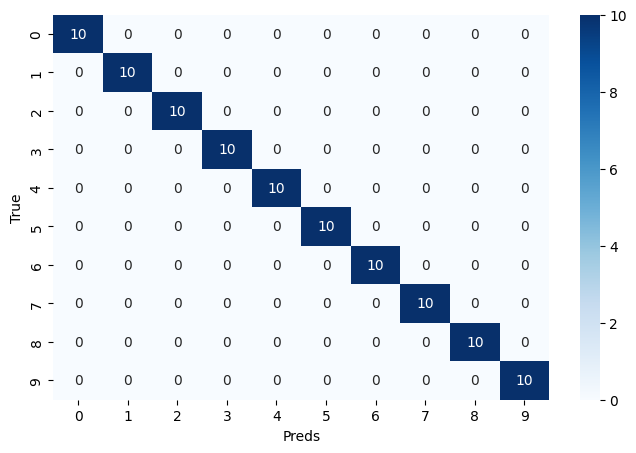

In [69]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(tru, pred)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Preds')
plt.ylabel('True')
plt.show()

In [129]:
check_preds_dict = {}

for i in scapper_acoustic_scenes:
    check_preds_dict[i] = [0 for j in range(40)]

for i in randomly_chosen_files.keys():
    for j in randomly_chosen_files[i][0]:
        prediction_list = predictions_dictionary[os.path.join(SCAPPER_AUD_DIR,j)]
        for k in prediction_list:
            print(k, i)
            if k != i:
                check_preds_dict[i][(prediction_list.index(k))] = check_preds_dict[i][(prediction_list.index(k))]+1
                #print(check_preds_dict[i][(prediction_list.index(k))])

restaurant bus
openairmarket bus
bus bus
bus bus
bus bus
bus bus
bus bus
bus bus
supermarket bus
tube bus
bus bus
bus bus
bus bus
restaurant bus
bus bus
bus bus
restaurant bus
tube bus
bus bus
bus bus
bus bus
supermarket bus
bus bus
bus bus
restaurant bus
tube bus
bus bus
bus bus
bus bus
restaurant bus
bus bus
bus bus
restaurant bus
bus bus
bus bus
bus bus
bus bus
bus bus
bus bus
bus bus
bus bus
openairmarket bus
bus bus
bus bus
bus bus
bus bus
bus bus
bus bus
restaurant bus
tube bus
bus bus
bus bus
bus bus
bus bus
bus bus
bus bus
restaurant bus
tube bus
bus bus
bus bus
bus bus
supermarket bus
bus bus
bus bus
supermarket bus
tube bus
bus bus
bus bus
bus bus
supermarket bus
bus bus
bus bus
supermarket bus
bus bus
bus bus
bus bus
bus bus
bus bus
bus bus
bus bus
restaurant bus
openairmarket bus
bus bus
bus bus
bus bus
tube bus
bus bus
bus bus
restaurant bus
tube bus
bus bus
bus bus
bus bus
supermarket bus
bus bus
bus bus
supermarket bus
bus bus
bus bus
bus bus
bus bus
supermarket bus
bus 

In [130]:
pd.DataFrame(check_preds_dict)

,bus,busystreet,office,openairmarket,park,quietstreet,restaurant,supermarket,tube,tubestation
0,33,46,35,9,40,56,45,32,40,48
1,19,6,18,0,13,2,6,37,21,0
2,0,159,144,172,194,166,118,182,191,129
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,5,0,0,0
5,4,44,1,45,4,8,41,17,0,33
6,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,5,0,0
8,13,33,9,29,14,16,8,3,10,24
9,23,20,12,14,25,38,28,15,0,61


In [101]:
x_list = []
for i in randomly_chosen_files.keys():
    #test_dict[i] = {}
    inner_list = []
    for j in randomly_chosen_files[i][0]:
        prediction_list = predictions_dictionary[os.path.join(SCAPPER_AUD_DIR,j)]
        for k in prediction_list:
            if k != i:
                #print(prediction_list.index(k), i)
                inner_list.append(prediction_list.index(k))
    x_list.append(inner_list)
        


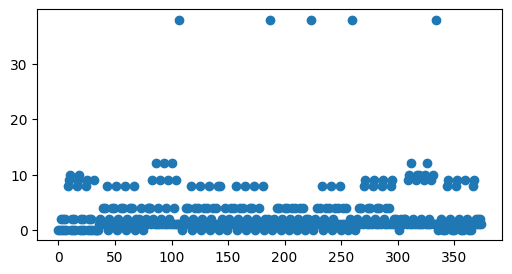

In [105]:
y_axis = [i for i in range(41)]

plt.figure(figsize=(6, 3))
plt.scatter([i for i in range((len(x_list[7])))], x_list[7])


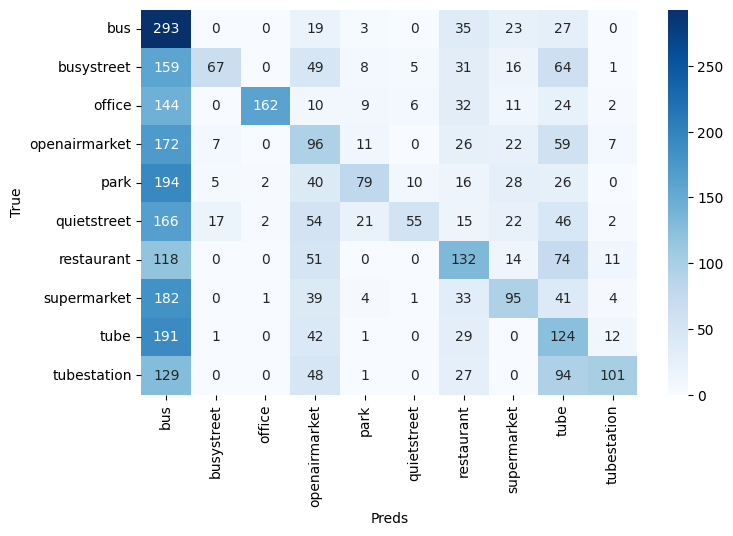

In [132]:
tru = []
preds = []

for i in scapper_acoustic_scenes:
    for j in randomly_chosen_files[i][0]:
        audio_fname = os.path.join(SCAPPER_AUD_DIR, j)
        prediction_list = predictions_dictionary[os.path.join(SCAPPER_AUD_DIR,j)]
        for k in prediction_list:
            tru.append(i)
            preds.append(k)

cm = confusion_matrix(tru, preds)

plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=scapper_acoustic_scenes, yticklabels=scapper_acoustic_scenes)
plt.xlabel('Preds')
plt.ylabel('True')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


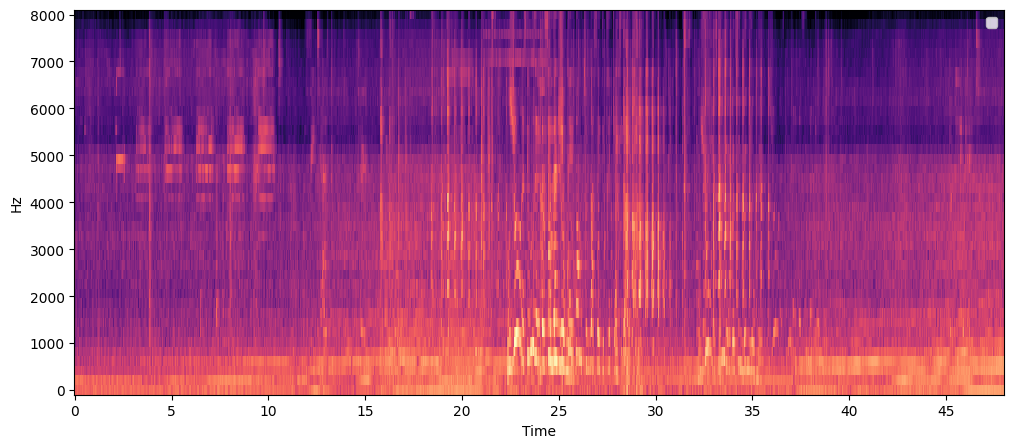

In [136]:
import librosa
import matplotlib.pyplot as plt

sample_file = '../audioData/sythenticSoundscenes/test/bus1_9.wav'
audio = audio_utils.load_audio_from_file(sample_file)
log_mel_feats = audio_utils.get_log_melSpectrogram(audio)

plt.figure(figsize=(12, 5))
librosa.display.specshow(log_mel_feats.squeeze().numpy(), x_axis='time', y_axis='linear', sr=16000)
plt.legend()

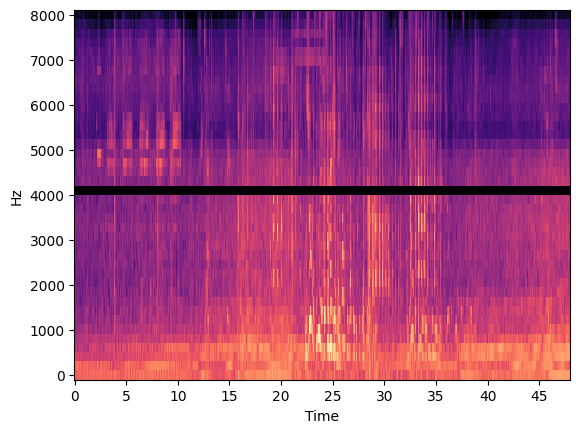

In [137]:
new_log_mel = zero_signal(log_mel_feats,20)
#log_mel_feats[0][25] = torch.ones(log_mel_feats[0][8].shape) * log_mel_feats.min()
librosa.display.specshow(log_mel_feats.squeeze().numpy(), x_axis='time', y_axis='linear', sr=16000) #new_log_mel

In [110]:
torch.ones(log_mel_feats[0].shape) * log_mel_feats.min()

tensor([[-80., -80., -80.,  ..., -80., -80., -80.],
        [-80., -80., -80.,  ..., -80., -80., -80.],
        [-80., -80., -80.,  ..., -80., -80., -80.],
        ...,
        [-80., -80., -80.,  ..., -80., -80., -80.],
        [-80., -80., -80.,  ..., -80., -80., -80.],
        [-80., -80., -80.,  ..., -80., -80., -80.]])

In [88]:
torch.ones(new_log_mel[0].shape) * 0.2

tensor([[0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
        [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
        [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
        ...,
        [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
        [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
        [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000]])

In [73]:
model.eval()
with torch.inference_mode():
    output = model(log_mel_feats.unsqueeze(0))
    #print(output)

torch.argmax(torch.sigmoid(output))

tensor(2)

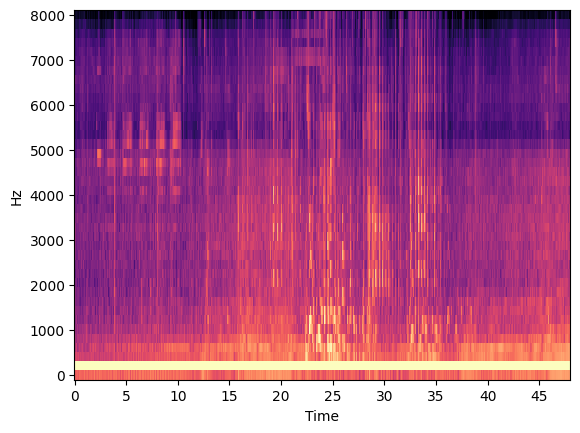

In [74]:
log_mel_feats[0][1] = torch.zeros(log_mel_feats[0][5].shape)

librosa.display.specshow(log_mel_feats.squeeze().numpy(), x_axis='time', y_axis='linear', sr=16000)

In [75]:
model.eval()
with torch.inference_mode():
    output = model(log_mel_feats.unsqueeze(0))

torch.argmax(torch.sigmoid(output))

tensor(0)